## Backtesting with a MACD- and RSI-Based Strategy for Swing Trading

This is an example of how a simple algorithmic trading strategy based on MACD (Moving Average Converge Divergence) and RSI (Relative Strength Index) can be implemented for backtesting and to calculate the expected returns.
<br>
<br> The strategy is as follows:
- Buy Signal: RSI > 30 and MACD histogram > 0
- Sell Signal: RSI < 70 or MACD histogram < 0

As an example, the strategy will be applied on the daily share price data for GlaxoSmithKline (GSK) stock (as listed on the London Stock Exchange) covering a period from April 2018  -  2023 (approximately a 5-year period. The data were downloaded from Yahoo Finance as a csv file to keep things simple for now).

**Note:**
- I share my code here for *educational purposes only*. The code can be used a starting point to develop more advanced backtesting strategies, but please don't use it in its current form to execute real trades in the financial markets using your own hard-earned cash (or, worse, someone else's cash).
- In this simple strategy, we are only going to go long when a signal arises & sell at the appropriate time (we're not going to short anything at this point). Fees, spread and slippage have not been accounted for. Please do your own due diligence.

### Section 1 - Load Data & Set Date as Index

In [26]:
# import relevant libraries & modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

In [27]:
# load the data & set the Date as the index
df = pd.read_csv('GSK.L.csv')
df.sort_values(by='Date')
df.index = pd.to_datetime(df['Date'])
df = df.drop(['Date'], axis=1)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-04-16,1434.880249,1437.297974,1412.516968,1418.964111,1051.669434,8476269
2018-04-17,1421.583252,1425.411255,1409.696411,1422.993530,1054.656128,7119895
2018-04-18,1426.418457,1437.700928,1417.755249,1432.059692,1061.375244,11550718
2018-04-19,1434.275879,1434.477417,1414.531738,1417.755249,1050.773560,7421527
2018-04-20,1429.440552,1445.558350,1424.605347,1440.521484,1067.646729,9710817
...,...,...,...,...,...,...
2023-04-06,1495.000000,1531.000000,1492.599976,1523.000000,1523.000000,7088057
2023-04-11,1517.000000,1527.599976,1501.199951,1506.400024,1506.400024,15767636
2023-04-12,1507.400024,1524.400024,1503.000000,1512.599976,1512.599976,5951360


### Section 2 - Technical Analysis Indicators
In this section, functions to calculate MACD, RSI and EMAs (exponential moving averages) are defined.

In [28]:
# Define the function for EMAs

def EMA(data):

    ema1 = 50
    ema2 = 100
    
    data['EMA50'] = data['Close'].ewm(span=ema1, adjust=False, min_periods=ema1).mean()
    data['EMA100'] = data['Close'].ewm(span=ema2, adjust=False, min_periods=ema2).mean()

    return(data)

In [29]:
# Define the function for MACD

def MACD(data):

    slow_ema = 17 # this is usually 26
    fast_ema = 8 # this is usually 12
    smooth_ema = 9

    data['slow_EMA'] = data['Close'].ewm(span=slow_ema, adjust=False, min_periods=slow_ema).mean()
    data['fast_EMA'] = data['Close'].ewm(span=fast_ema, adjust=False, min_periods=fast_ema).mean()

    # generate MACD, signal lines & the histogram
    data['MACD'] = data['fast_EMA'] - data['slow_EMA']
    data['MACD_Signal'] = data['MACD'].ewm(span=smooth_ema, adjust=False, min_periods=smooth_ema).mean()
    data['MACD_Histogram'] = data['MACD'] - data['MACD_Signal']

    return(data)

In [30]:
# Define the function for RSI

def RSI(data):

    delta = data['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = np.absolute(delta.where(delta < 0, 0))
    avg_gain = gain.rolling(window=13).mean()
    avg_loss = loss.rolling(window=13).mean()
    
    RS = avg_gain / avg_loss
    RSI = 100 - (100/(1 + RS))
    data['RSI'] = RSI
    data['Overbought'] = 70
    data['Oversold'] = 30

    return data

In [31]:
# call the functions to get EMAs, MACD, and RSI
df = EMA(df)
df = MACD(df)
df = RSI(df)

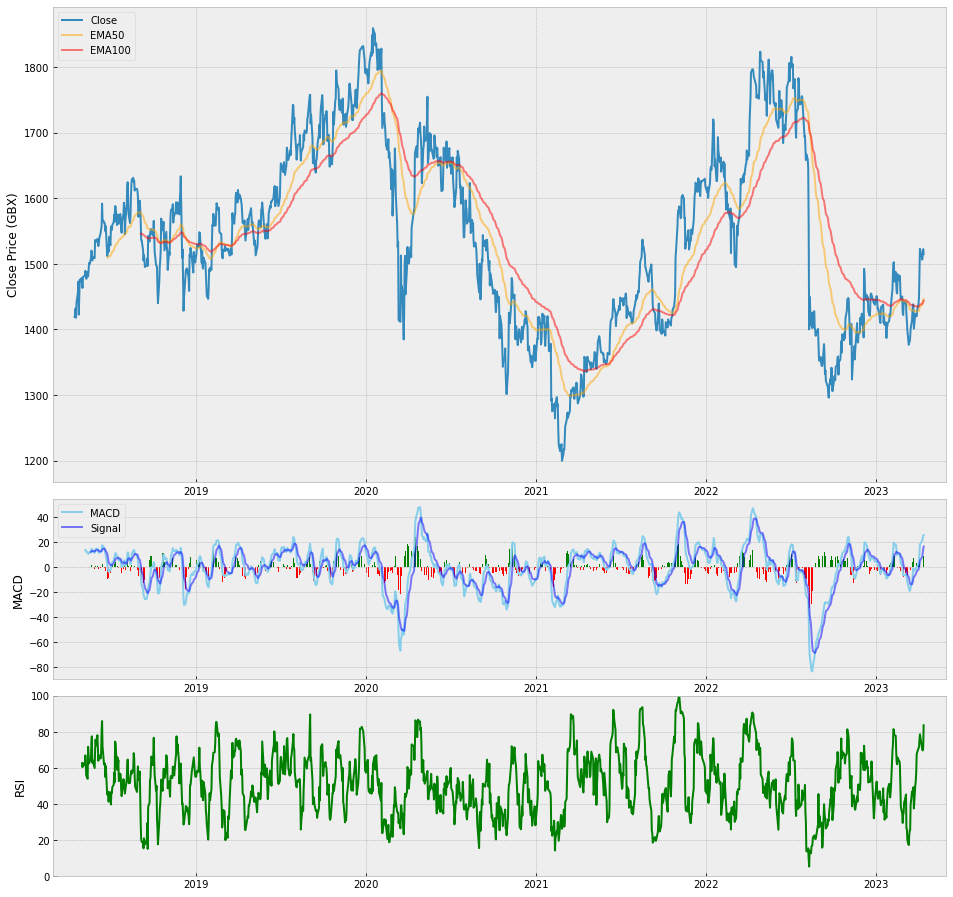

In [32]:
# visualise close price, EMAs, MACD & RSI

start_date = np.datetime64('2018-03-01')
end_date = np.datetime64('2023-06-01')

fig = plt.subplots(figsize=(16,16))
ax1 = plt.subplot2grid((9,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((9,1), (5,0), rowspan = 2, colspan = 1)
ax3 = plt.subplot2grid((9,1), (7,0), rowspan = 2, colspan = 1)

# visualisation of close price & EMAs overlaid on them
ax1.plot(df['Close'], label='Close')
ax1.plot(df['EMA50'], label='EMA50',  c='orange', alpha=0.5)
ax1.plot(df['EMA100'], label='EMA100', c='red', alpha=0.5)
ax1.set_ylabel('Close Price (GBX)')
ax1.set_xbound(lower = start_date, upper = end_date)
ax1.legend(loc='upper left')

# visualisation of MACD lines
ax2.plot(df['MACD'], color='skyblue', label='MACD')
ax2.plot(df['MACD_Signal'], color='blue', alpha=0.5, label='Signal')

# visualisation of MACD histogram
for i in range(len(df['Close'])):
    if df['MACD_Histogram'][i] < 0:
        ax2.bar(df.index[i], df['MACD_Histogram'][i], color='red')
    else:
        ax2.bar(df.index[i], df['MACD_Histogram'][i], color='green')

ax2.set_ylabel('MACD')
ax2.set_xbound(lower = start_date, upper = end_date)
ax2.legend(loc='upper left')

# visualisation of RSI
ax3.plot(df['RSI'], label = 'RSI', color='green')
ax3.set_ylabel('RSI')
ax3.set_ylim([0,100])
ax3.set_xbound(lower = start_date, upper = end_date)

plt.show()

Note: the exponential moving averages (EMAs) are shown just to serve as an overall visualisation guide to track price movements. They are not a part of the trading strategy.

In [33]:
# make a copy of the dataframe for further analyses
# drop unused columns to simplify things
df2 = df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume', 'slow_EMA', 'fast_EMA', 'MACD', 'MACD_Signal', 'Overbought', 'Oversold'], axis=1)
df2.columns # check what columns we have in df2

Index(['Close', 'EMA50', 'EMA100', 'MACD_Histogram', 'RSI'], dtype='object')

### Section 3 - Trading Strategy
Reminder for the trading strategy:
- Buy Signal --> RSI > 30 and MACD histogram > 0
- Sell SIgnal --> RSI < 70 or MACD histogram < 0

In [34]:
# define the position tracker and set as 0 initially
df2['position_tracker'] = ''

# define the entry & exit signals
entry_signal = (df2['MACD_Histogram'] > 0) & (df2['RSI'] > 30)
exit_signal = (df2['MACD_Histogram'] < 0) | (df2['RSI'] > 70)

# set position tracker as 1 at entry & set back to 0 upon selling
df2['position_tracker'] = np.where(exit_signal, 0, np.nan)
df2['position_tracker'] = np.where(entry_signal, 1, df2['position_tracker'])
df2['position_tracker'].ffill(inplace=True)

# record the price when position == 1
df2['in_position'] = np.where(df2['position_tracker'] == 1, df2['Close'], np.nan)

In [35]:
# get the entry prices

df2['entry_price'] = ''

for i in range(len(df2)):
    if (df2['position_tracker'][i-1] != 1) and (df2['position_tracker'][i] == 1):
        df2['entry_price'][i] = df['Close'][i]

df2['entry_price'] = pd.to_numeric(df2['entry_price']) # make sure to convert to a numerical data type

/var/folders/7l/b7q7m6_92vd8wdnm3n_8cn800000gn/T/ipykernel_81926/821707226.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['entry_price'][i] = df['Close'][i]


In [36]:
# get the exit prices

df2['exit_price'] = ''

for i in range(len(df2)):
    if (df2['position_tracker'][i-1] == 1) and (df2['position_tracker'][i] == 0):
        df2['exit_price'][i] = df['Close'][i]

df2['exit_price'] = pd.to_numeric(df2['exit_price']) # make sure to convert to a numerical data type

/var/folders/7l/b7q7m6_92vd8wdnm3n_8cn800000gn/T/ipykernel_81926/2358262455.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['exit_price'][i] = df['Close'][i]


In [37]:
# double-check the data types
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1263 entries, 2018-04-16 to 2023-04-14
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Close             1263 non-null   float64
 1   EMA50             1214 non-null   float64
 2   EMA100            1164 non-null   float64
 3   MACD_Histogram    1239 non-null   float64
 4   RSI               1251 non-null   float64
 5   position_tracker  1243 non-null   float64
 6   in_position       574 non-null    float64
 7   entry_price       65 non-null     float64
 8   exit_price        64 non-null     float64
dtypes: float64(9)
memory usage: 98.7 KB


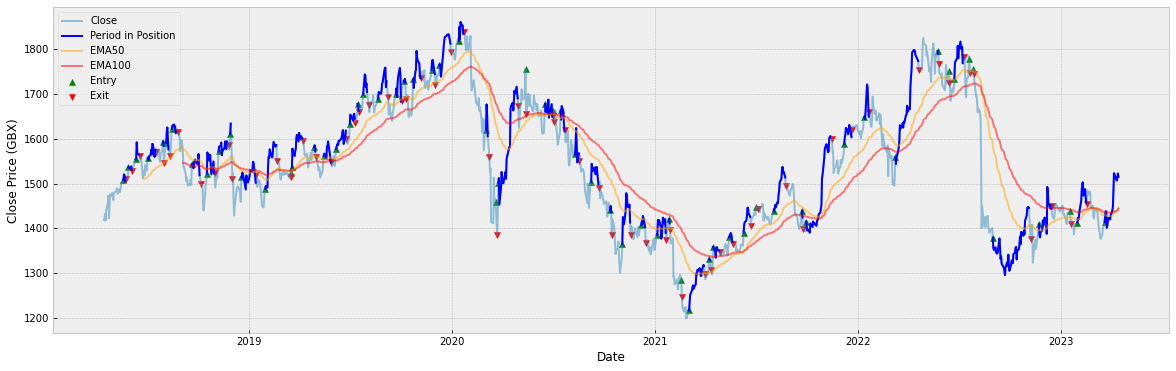

In [38]:
# visualise the entries and exits overlaid on the price

fig, ax = plt.subplots(figsize=(20,6))
ax.plot(df2['Close'], label = 'Close', alpha = 0.5)
ax.plot(df2['in_position'], label = 'Period in Position', color = 'blue')
ax.plot(df2['EMA50'], label='EMA50',  c='orange', alpha = 0.5)
ax.plot(df2['EMA100'], label='EMA100', c='red', alpha = 0.5)
ax.scatter(df2.index, df2['entry_price'], label = 'Entry', marker = '^', color = 'green')
ax.scatter(df2.index, df2['exit_price'], label = 'Exit', marker = 'v', color = 'red')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price (GBX)')
ax.legend(loc = 'upper left')
plt.show()

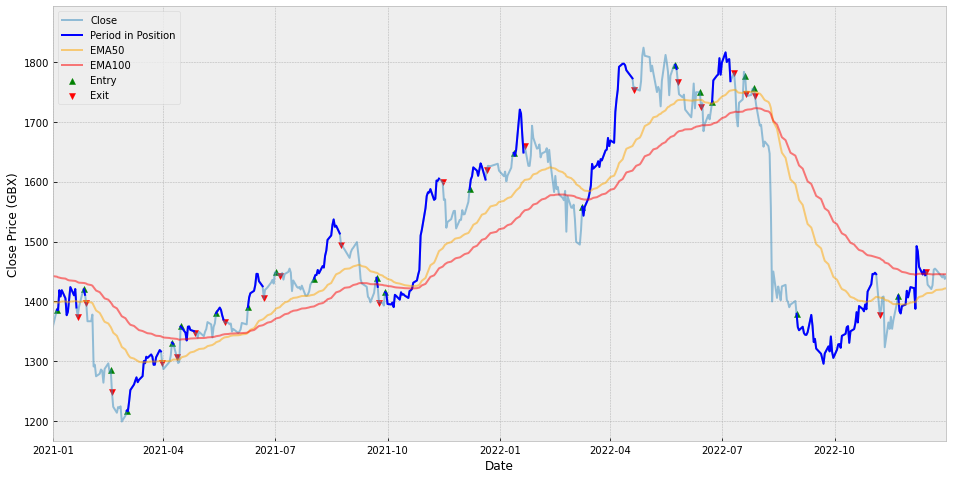

In [39]:
# visualise the entries and exits overlaid on the price - zoomed in for 2021 - 2022 only

fig, ax = plt.subplots(figsize=(16,8))
ax.plot(df2['Close'], label = 'Close', alpha = 0.5)
ax.plot(df2['in_position'], label = 'Period in Position', color = 'blue')
ax.plot(df2['EMA50'], label='EMA50',  c='orange', alpha = 0.5)
ax.plot(df2['EMA100'], label='EMA100', c='red', alpha = 0.5)
ax.scatter(df2.index, df2['entry_price'], label = 'Entry', marker = '^', color = 'green')
ax.scatter(df2.index, df2['exit_price'], label = 'Exit', marker = 'v', color = 'red')
ax.set_xlim(left=np.datetime64('2021-01-01'), right=np.datetime64('2022-12-31'))
ax.set_xlabel('Date')
ax.set_ylabel('Close Price (GBX)')
ax.legend(loc = 'upper left')
plt.show()

A quick glance at the graph above shows that there are a few trades that resulted in losses, as expected from a simple strategy like this one. Also, we are usually in a position for around a few days up to 1 month.

### Section 4 - P & L Calculations
In this section, we'll calculate the overall profit / loss generated using the strategy. The assumptions are as follows:
- our starting capital is GBP 10,000 
- our position size per trade is GBP 200 (i.e. 2% of starting capital)
- we use 50 x leverage per trade
- Fees, spreads & slippage have not been taken into account

In [40]:
# make a list all prices in all instances of entry (buy) trades
buy_prices = list(df2['entry_price'].dropna())

# count the total number of entry trades
print(f"The total number of entry: {len(buy_prices)}")

# make a list all prices in all instances of exit (sell) trades
sell_prices = list(df2['exit_price'].dropna())

# count the total number of exit trades
print(f"The total number of exit: {len(sell_prices)}")

The total number of entry: 65
The total number of exit: 64


There are 65 entry transactions and 64 exit transactions, indicating that the last entry trade has not been closed. So let's assume we'll sell at the end of the the period.

In [41]:
# append the last close price to the sell_prices list
sell_prices.append(df['Close'][-1])

# re-count the total number of exit trades
print(f"The total number of exit: {len(sell_prices)}")

The total number of exit: 65


In [42]:
# define the position size per trade & leverage
initial_investment = 10000
size_per_trade = 200
leverage = 50

# calculate the differences between entry & exit price for every trade
PnL = pd.DataFrame({'Buy (GBX)': buy_prices, 'Sell (GBX)': sell_prices})
PnL['Difference (GBX)'] = PnL['Sell (GBX)'] - PnL['Buy (GBX)']

# calculate the number of units of stocks bought for every trade with and without leverage
# Note: GBX is in pence (1 GBP = 100 GBX)
PnL['Units Bought'] = (size_per_trade*100) / PnL['Buy (GBX)']
PnL['Units Bought_leveraged'] = (size_per_trade*leverage*100) / PnL['Buy (GBX)']

# calculate P/L per trade
PnL['PnL (GBP)'] = (PnL['Sell (GBX)'] / 100 * PnL['Units Bought']) - size_per_trade
PnL['PnL (GBP)_leveraged'] = (PnL['Sell (GBX)'] / 100 * PnL['Units Bought_leveraged']) - (size_per_trade * leverage)

# calculate cumulative P/L over time
PnL['Cumul_PnL (GBP)'] = PnL['PnL (GBP)'].cumsum()
PnL['Cumul_PnL (GBP)_leveraged'] = PnL['PnL (GBP)_leveraged'].cumsum()

# calculate the capital growth over time
PnL['Investment_Value'] = initial_investment + PnL['Cumul_PnL (GBP)']
PnL['Investment_Value_leveraged'] = initial_investment + PnL['Cumul_PnL (GBP)_leveraged']

In [43]:
# quick check of the PnL dataframe
PnL.head()

,Buy (GBX),Sell (GBX),Difference (GBX),Units Bought,Units Bought_leveraged,PnL (GBP),PnL (GBP)_leveraged,Cumul_PnL (GBP),Cumul_PnL (GBP)_leveraged,Investment_Value,Investment_Value_leveraged
0,1507.812988,1511.036621,3.223633,13.264244,663.212221,0.427591,21.379528,0.427591,21.379528,10000.427591,10021.379528
1,1536.421997,1527.154297,-9.267700,13.017257,650.862850,-1.206400,-60.320016,-0.778810,-38.940488,9999.221190,9961.059512
2,1553.547119,1561.404419,7.857300,12.873765,643.688233,1.011530,50.576516,0.232721,11.636027,10000.232721,10011.636027
3,1557.375000,1569.463257,12.088257,12.842122,642.106108,1.552389,77.619437,1.785109,89.255464,10001.785109,10089.255464
4,1593.237061,1545.286743,-47.950318,12.553060,627.652987,-6.019232,-300.961603,-4.234123,-211.706139,9995.765877,9788.293861


In [44]:
# sum all the differences between Sell and Buy prices
PnL['Difference (GBX)'].sum()

80.17651000000023

Although small (only around 80 pence), the overall difference between Sell and Buy prices is positive. To gain a better idea, we'll plot the value of our investment after every trade (we'll also plot our capital over time with leverage).

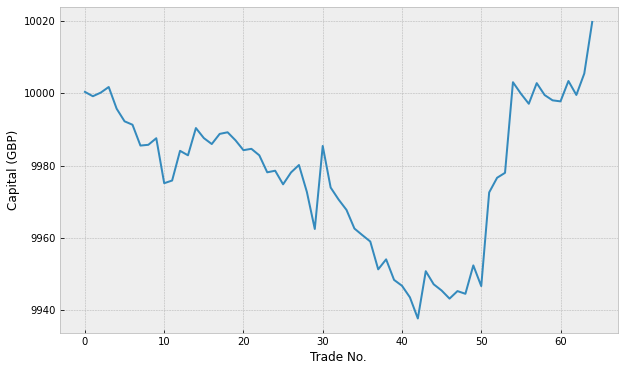

In [45]:
PnL['Investment_Value'].plot(figsize=(10,6))
plt.ylabel('Capital (GBP)')
plt.xlabel('Trade No.')
plt.show()

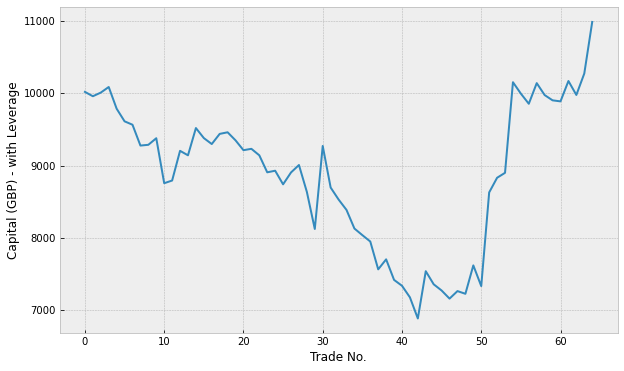

In [46]:
PnL['Investment_Value_leveraged'].plot(figsize=(10,6))
plt.ylabel('Capital (GBP) - with Leverage')
plt.xlabel('Trade No.')
plt.show()
plt.show()

With this strategy, we generally lost money for around the first 50 trades. Only in the last 10 to 15 trades that we started makiing some profits. Now, we'll calculate the maximum drawdowns and the actual gains by the end of the period.

In [47]:
# drawdown calculations

drawdown = round(PnL['Cumul_PnL (GBP)'].min(), 2)
drawdown_leveraged = round(PnL['Cumul_PnL (GBP)_leveraged'].min(), 2)

print(f'Maximum drawdown (without using leverage): GBP {drawdown}')
print(f'Maximum drawdown (using 50 x leverage): GBP {drawdown_leveraged}')

Maximum drawdown (without using leverage): GBP -62.37
Maximum drawdown (using 50 x leverage): GBP -3118.63


Although we only lost around GBP 62 throughout the period, when we use 50 x leverage, the maximum drawdown was more than GBP 3000 as expected since using leverage magnifies all gains and losses.

In [48]:
# calculations of capital value by the end of period

end_value = round(initial_investment + (PnL['PnL (GBP)'].sum()), 2)
end_value_leveraged = round(initial_investment + (PnL['PnL (GBP)_leveraged'].sum()), 2)

print(f'Capital by the end of period (without using leverage): GBP {end_value}')
print(f'Capital by the end of period (using 50 x leverage): GBP {end_value_leveraged}')

Capital by the end of period (without using leverage): GBP 10019.81
Capital by the end of period (using 50 x leverage): GBP 10990.45


In [49]:
pct_end_gain = round(((PnL['Cumul_PnL (GBP)'].iloc[-1]) / initial_investment) * 100, 2)
pct_end_gain_leveraged = round(((PnL['Cumul_PnL (GBP)_leveraged'].iloc[-1]) / initial_investment) * 100, 2)

print(f'Percent gain by the end of period (without using leverage): {pct_end_gain} %')
print(f'Percent gain by the end of period (using 50 x leverage): {pct_end_gain_leveraged} %')

Percent gain by the end of period (without using leverage): 0.2 %
Percent gain by the end of period (using 50 x leverage): 9.9 %


As a result, the value of our investment had slightly gone up by the end of the period: + 0.2 % (+ GBP 19.80) without leverage, or + 9.9 % (+ GBP 990.45) with 50 x leverage. The gains are now compared to the gain if we simply buy at the beginning of the period and sell at the end of the period (below).

In [50]:
# Calculations of buy-and-hold (BH) strategy P/L

BH_entry_price = PnL['Buy (GBX)'].iloc[0]
BH_exit_price = PnL['Sell (GBX)'].iloc[-1]

BH_no_of_units = (initial_investment * 100) / BH_entry_price
BH_end_value = round((BH_exit_price / 100 * BH_no_of_units), 2)
BH_pct_end_gain = round((BH_exit_price / 100 * BH_no_of_units) / initial_investment, 2)

print(f'Capital by the end of period (buy-and-hold): GBP {BH_end_value}')
print(f'Percent gain by the end of period (buy-and-hold): {BH_pct_end_gain} %')

Capital by the end of period (buy-and-hold): GBP 10047.67
Percent gain by the end of period (buy-and-hold): 1.0 %


**Conclusions:**
- The percent gain by the end of the period is 1 % or less, whether we buy-and-hold, or if we adopt the MACD- and RSI-based active trading strategy outlined in this notebook.
- We only gain around 10 % after 5 years of trading if we use 50 x leverage (which comes with its own associated risks, such as a larger drawdown and fees incurred - which have not been covered in the code here).
- In the future, improvements to the strategy may include different combinations of indicators (or indicator parameter settings) or implementation of stop-losses.
- The choice of GSK stock here was deliberate because its price movements sometimes don't really follow a trend and can be choppy. Therefore, the use of MACD (which is essentially a lagging trend-following indicator) may not be optimal for this stock.
- In the future, we can develop a better stock selection system and simply apply the strategy to different stocks that show overall long-term trends.

Sources of inspirations & ideas:
- https://www.youtube.com/@ComputerSciencecompsci112358
- https://medium.com/codex/algorithmic-trading-with-macd-in-python-1c2769a6ad1b